In [180]:
from google.cloud import vision
from google.protobuf import field_mask_pb2 as field_mask

from google.cloud import storage
from IPython.display import Image, display

In [40]:
import os
from dotenv import load_dotenv

load_dotenv()
project_id = os.environ.get("project_id")
location = os.environ.get("location")

# Main methods

**Create product set**

In [7]:
def create_product_set(product_set_id, product_set_display_name):
    """
        product_set_id: Id of the product set.
        product_set_display_name: Display name of the product set.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product set with the product set specification in the region.
    product_set = vision.ProductSet(
            display_name=product_set_display_name)

    # The response is the product set with `name` populated.
    response = client.create_product_set(
        parent=location_path,
        product_set=product_set,
        product_set_id=product_set_id)

    # Display the product set information.
    print('Product set name: {}'.format(response.name))

**Create product**

In [3]:
def create_product(product_id, product_display_name, product_category):
    """
        product_id: Id of the product.
        product_display_name: Display name of the product.
        product_category: Category of the product.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product with the product specification in the region.
    # Set product display name and product category.
    product = vision.Product(
        display_name=product_display_name,
        product_category=product_category)

    # The response is the product with the `name` field populated.
    response = client.create_product(
        parent=location_path,
        product=product,
        product_id=product_id)

    # Display the product information.
    print('Product name: {}'.format(response.name))

**Add product to product set**

In [8]:
def add_product_to_product_set(product_id, product_set_id):
    """
        product_id: Id of the product.
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Add the product to the product set.
    client.add_product_to_product_set(
        name=product_set_path, product=product_path)
    print('Product added to product set.')

**Create reference image for product**

In [13]:
def create_reference_image(product_id, reference_image_id, gcs_uri):
    """
        product_id: Id of the product.
        reference_image_id: Id of the reference image.
        gcs_uri: Google Cloud Storage path of the input image.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Create a reference image.
    reference_image = vision.ReferenceImage(uri=gcs_uri)

    # The response is the reference image with `name` populated.
    image = client.create_reference_image(
        parent=product_path,
        reference_image=reference_image,
        reference_image_id=reference_image_id)

    # Display the reference image information.
    print('Reference image name: {}'.format(image.name))
    print('Reference image uri: {}'.format(image.uri))

**Import products from csv import file in Cloud Storage to product set**

In [ ]:
def import_product_sets(gcs_uri):
    """
        gcs_uri: Google Cloud Storage URI.
            Target files must be in Product Search CSV format.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Set the input configuration along with Google Cloud Storage URI
    gcs_source = vision.ImportProductSetsGcsSource(
        csv_file_uri=gcs_uri)
    input_config = vision.ImportProductSetsInputConfig(
        gcs_source=gcs_source)

    # Import the product sets from the input URI.
    response = client.import_product_sets(
        parent=location_path, input_config=input_config)

    print('Processing operation name: {}'.format(response.operation.name))
    # synchronous check of operation status
    result = response.result()
    print('Processing done.')

    for i, status in enumerate(result.statuses):
        print('Status of processing line {} of the csv: {}'.format(
            i, status))
        # Check the status of reference image
        # `0` is the code for OK in google.rpc.Code.
        if status.code == 0:
            reference_image = result.reference_images[i]
            print(reference_image)
        else:
            print('Status code not OK: {}'.format(status.message))

**Find products similar to a Cloud Storage image file**

In [187]:
def get_similar_products_uri(product_set_id, product_category, image_uri, filter):
    """
        product_set_id: Id of the product set.
        product_category: Category of the product.
            supported categories:homegoods-v2, apparel-v2, toys-v2, packagedgoods-v1, general-v1
            legacy still supported categories:homegoods, apparel ,toys
        image_uri: Cloud Storage location of image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: style = women
    """        
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Create annotate image request along with product search feature.
    image_source = vision.ImageSource(image_uri=image_uri)
    image = vision.Image(source=image_source)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)

    print(response)
    
    index_time = response.product_search_results.index_time
    print('Product set index time: ')
    print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    for result in results:
        product = result.product

        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))

        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: {}\n'.format(product.product_labels))

**Find products similar to a Cloud Storage image file and display images**

In [196]:
def get_similar_products_uri_and_display(product_set_id, product_category, image_uri, filter, threshold):
    """
        product_set_id: Id of the product set.
        product_category: Category of the product.
            supported categories:homegoods-v2, apparel-v2, toys-v2, packagedgoods-v1, general-v1
            legacy still supported categories:homegoods, apparel ,toys
        image_uri: Cloud Storage location of image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: style = women
        threshold: 
    """    
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Create annotate image request along with product search feature.
    image_source = vision.ImageSource(image_uri=image_uri)
    image = vision.Image(source=image_source)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)
    
    # index_time = response.product_search_results.index_time
    # print('Product set index time: ')
    # print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    for result in results:
        product = result.product
        print('Score(Confidence): {}'.format(result.score))
        display_last_reference_image(product.name.split('/')[-1])
        
        """

        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: {}\n'.format(product.product_labels))
        """

# Helper methods

**List all product sets**

In [12]:
def list_product_sets():
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # List all the product sets available in the region.
    product_sets = client.list_product_sets(parent=location_path)

    # Display the product set information.
    for product_set in product_sets:
        print('Product set name: {}'.format(product_set.name))
        print('Product set id: {}'.format(product_set.name.split('/')[-1]))
        print('Product set display name: {}'.format(product_set.display_name))
        print('Product set index time: ')
        print(product_set.index_time)

**List products in a product set**

In [14]:
def list_products_in_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # List all the products available in the product set.
    products = client.list_products_in_product_set(name=product_set_path)

    # Display the product information.
    for product in products:
        print('Product name: {}'.format(product.name))
        print('Product id: {}'.format(product.name.split('/')[-1]))
        print('Product display name: {}'.format(product.display_name))
        print('Product description: {}'.format(product.description))
        print('Product category: {}'.format(product.product_category))
        print('Product labels: {}'.format(product.product_labels))

**List reference images of a product**

In [16]:
def list_reference_images(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # List all the reference images available in the product.
    reference_images = client.list_reference_images(parent=product_path)

    # Display the reference image information.
    for image in reference_images:
        print('Reference image name: {}'.format(image.name))
        print('Reference image id: {}'.format(image.name.split('/')[-1]))
        print('Reference image uri: {}'.format(image.uri))
        print('Reference image bounding polygons: {}'.format(
            image.bounding_polys))

**Get product set info**

In [18]:
def get_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Get complete detail of the product set.
    product_set = client.get_product_set(name=product_set_path)

    # Display the product set information.
    print('Product set name: {}'.format(product_set.name))
    print('Product set id: {}'.format(product_set.name.split('/')[-1]))
    print('Product set display name: {}'.format(product_set.display_name))
    print('Product set index time: ')
    print(product_set.index_time)

**Get product info**

In [17]:
def get_product(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Get complete detail of the product.
    product = client.get_product(name=product_path)

    # Display the product information.
    print('Product name: {}'.format(product.name))
    print('Product id: {}'.format(product.name.split('/')[-1]))
    print('Product display name: {}'.format(product.display_name))
    print('Product description: {}'.format(product.description))
    print('Product category: {}'.format(product.product_category))
    print('Product labels: {}'.format(product.product_labels))

**Get reference image info**

In [18]:
def get_reference_image(product_id, reference_image_id):
    """
        product_id: Id of the product.
        reference_image_id: Id of the reference image.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the reference image.
    reference_image_path = client.reference_image_path(
        project=project_id, location=location, product=product_id,
        reference_image=reference_image_id)

    # Get complete detail of the reference image.
    image = client.get_reference_image(name=reference_image_path)

    # Display the reference image information.
    print('Reference image name: {}'.format(image.name))
    print('Reference image id: {}'.format(image.name.split('/')[-1]))
    print('Reference image uri: {}'.format(image.uri))
    print('Reference image bounding polygons: {}'.format(image.bounding_polys))

**Display reference images for a product**

In [181]:
def display_last_reference_image(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # List all the reference images available in the product.
    reference_images = client.list_reference_images(parent=product_path)

    # Display the reference image information.
    for image in reference_images:
        display_blob_image(image.uri)

**Delete a product set**

In [19]:
def delete_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Delete the product set.
    client.delete_product_set(name=product_set_path)
    print('Product set deleted.')

**Delete a product**

In [20]:
def delete_product( product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Delete a product.
    client.delete_product(name=product_path)
    print('Product deleted.')

**Update product labels**

In [10]:
def update_product_labels(product_id, key, value):
    """
        product_id: Id of the product.
        key: The key of the label.
        value: The value of the label.
    """
    client = vision.ProductSearchClient()

    # Get the name of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Set product name, product label and product display name.
    # Multiple labels are also supported.
    key_value = vision.Product.KeyValue(key=key, value=value)
    product = vision.Product(
        name=product_path,
        product_labels=[key_value])

    # Updating only the product_labels field here.
    update_mask = field_mask.FieldMask(paths=['product_labels'])

    # This overwrites the product_labels.
    updated_product = client.update_product(
        product=product, update_mask=update_mask)

    # Display the updated product information.
    print('Product name: {}'.format(updated_product.name))
    print('Updated product labels: {}'.format(product.product_labels))

**Display blob image**

In [194]:
def display_blob_image(uri):
    client = storage.Client.create_anonymous_client()
    
    res = uri.split('/',3)
    image_bucket = res[2]
    image_blob = res[3]
    
    bucket = client.bucket(image_bucket)
    print(image_bucket)
    blob = bucket.blob(image_blob)
    print(image_blob)
    display(Image(blob.download_as_bytes()))

# Calls

Product set index time: 
2021-04-26 16:33:27.512589+00:00
Search results:
Product name: projects/jmoreirodemos/locations/us-west1/products/product_id57
Score(Confidence): 0.28808894753456116
cloud-ai-vision-data
product-search-tutorial/images/4695ee2870ba11e89e3ad20059124800.jpg


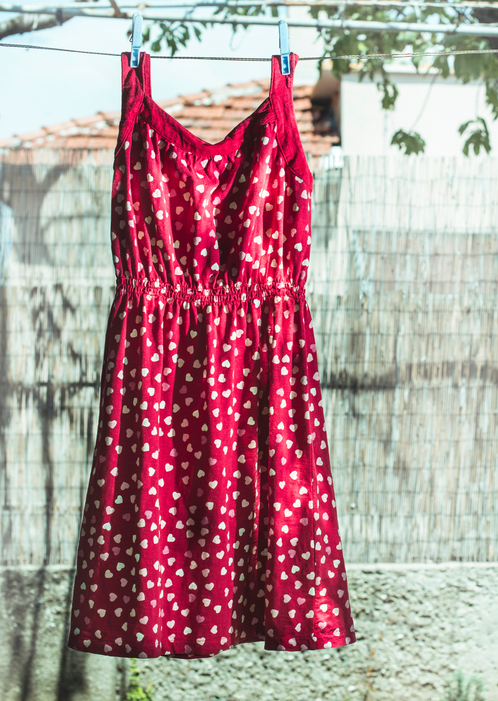

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id23
Score(Confidence): 0.27944156527519226
cloud-ai-vision-data
product-search-tutorial/images/469ae13370ba11e894f4d20059124800.jpg


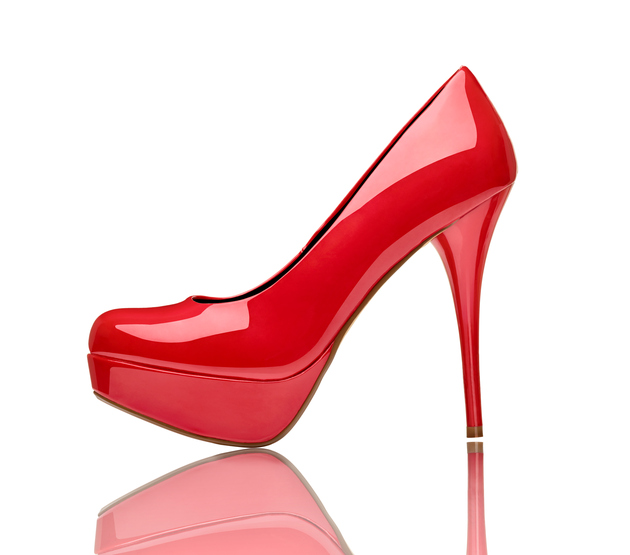

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id40
Score(Confidence): 0.27269741892814636
cloud-ai-vision-data
product-search-tutorial/images/469e902870ba11e8b3d8d20059124800.jpg


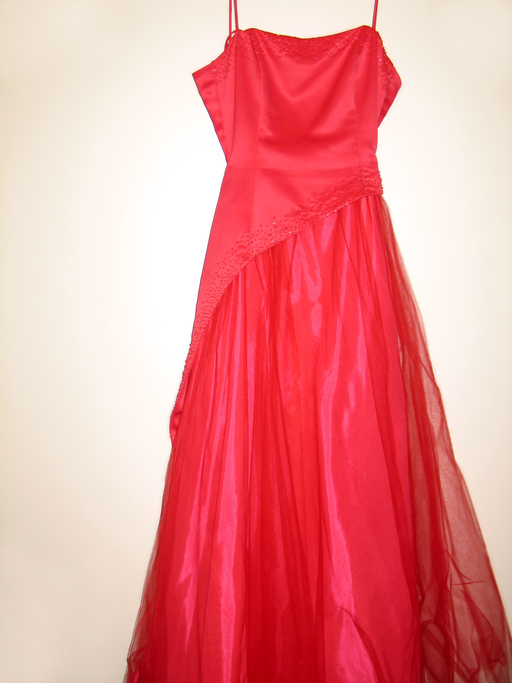

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id49
Score(Confidence): 0.27238714694976807
cloud-ai-vision-data
product-search-tutorial/images/4691cb2370ba11e88dfad20059124800.jpg


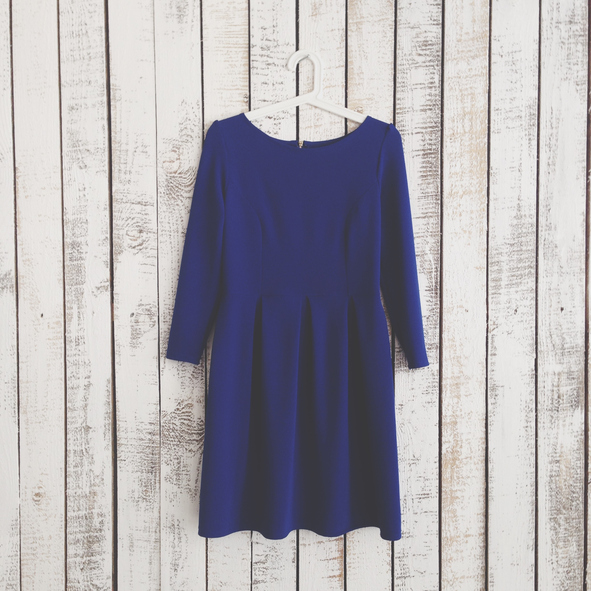

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id75
Score(Confidence): 0.2700890302658081
cloud-ai-vision-data
product-search-tutorial/images/46968f4c70ba11e89d0ad20059124800.jpg


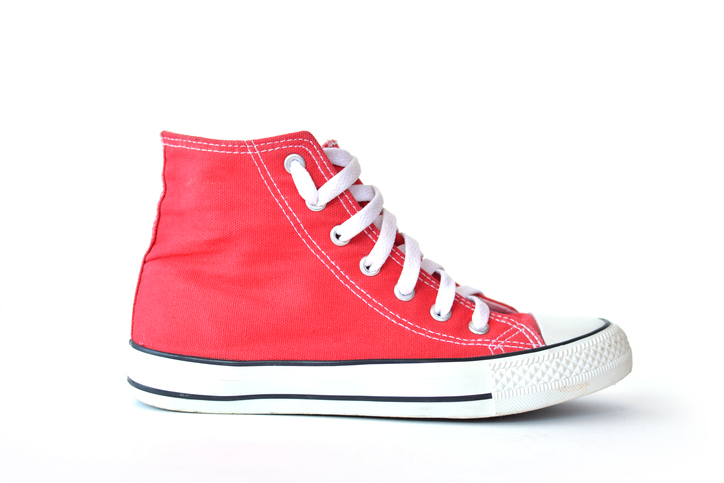

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id63
Score(Confidence): 0.26190584897994995
cloud-ai-vision-data
product-search-tutorial/images/4698cf5970ba11e8a168d20059124800.jpg


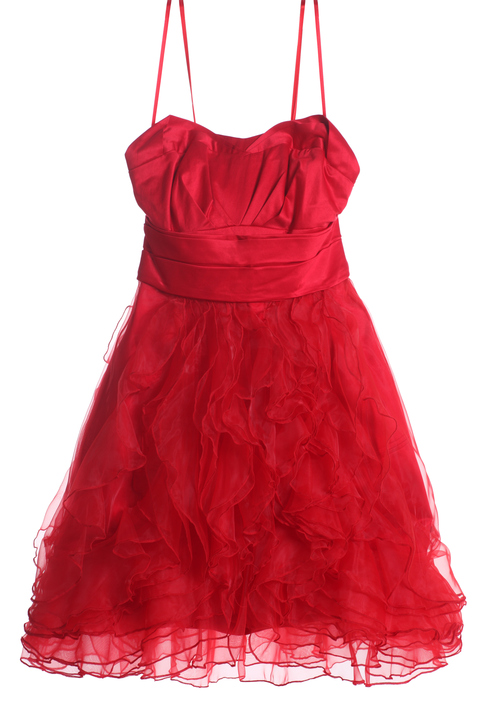

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id84
Score(Confidence): 0.2536753714084625
cloud-ai-vision-data
product-search-tutorial/images/469445d470ba11e8bdc4d20059124800.jpg


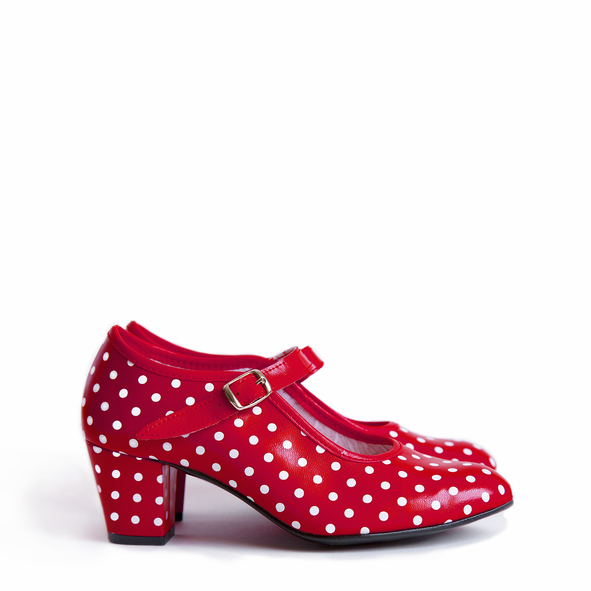

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id62
Score(Confidence): 0.24159547686576843
cloud-ai-vision-data
product-search-tutorial/images/4698a10570ba11e8886ad20059124800.jpg


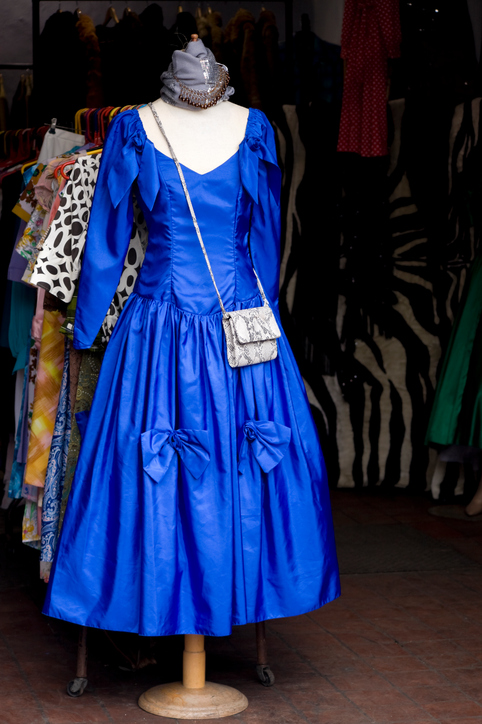

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id17
Score(Confidence): 0.24009573459625244
cloud-ai-vision-data
product-search-tutorial/images/468fa24a70ba11e8aac6d20059124800.jpg


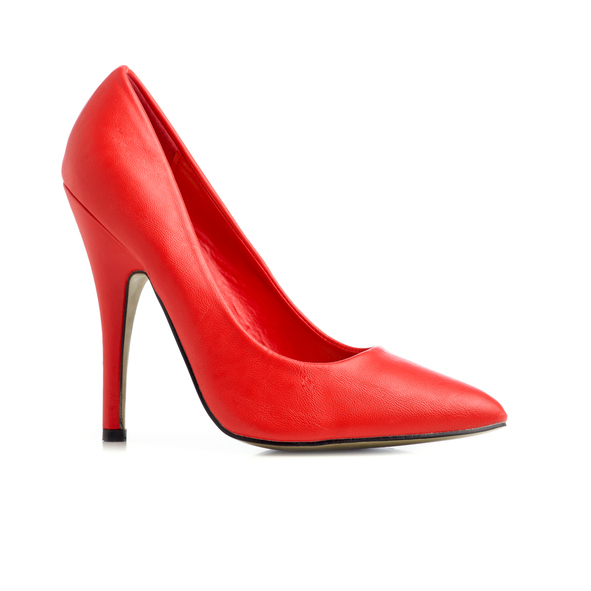

Product name: projects/jmoreirodemos/locations/us-west1/products/product_id39
Score(Confidence): 0.23953688144683838
cloud-ai-vision-data
product-search-tutorial/images/469e07de70ba11e8a336d20059124800.jpg


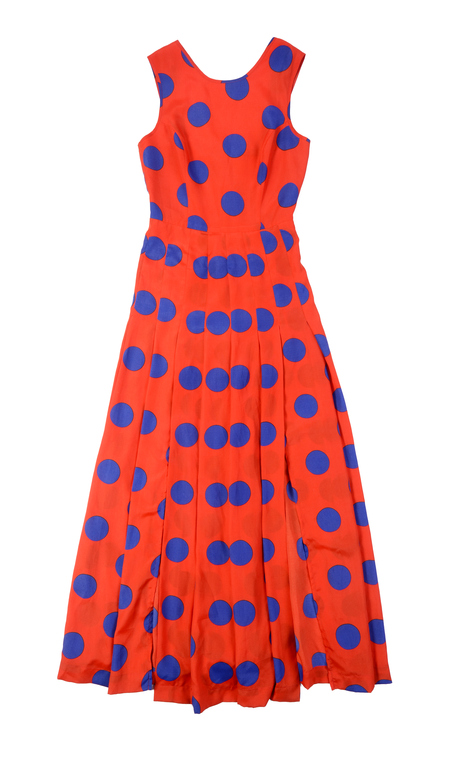

In [197]:
get_similar_products_uri_and_display("product_set0", "apparel-v2", "gs://testimages_jmoreiro/dresses/reddress.jpeg", "style=women")